<a href="https://colab.research.google.com/github/QiWang-GH/Qi_Wang.github.io/blob/master/AAE_based_CBEGAN_PLA_Electronics_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 6 - Generative Adversarial Network
This is the sample code for hw6 of 2022 Machine Learning course in National Taiwan University.

In this sample code, there are 5 sections:
1. Environment setting
2. Dataset preparation
3. Model setting
4. Train
5. Inference

Your goal is to do anime face generation, if you have any question, please discuss at NTU COOL

# Environment setting
In this section, we will prepare for the dataset and set some environment variable

## Download Dataset

In [1]:
# import warnings

# warnings.filterwarnings("error")
from google.colab import drive
drive.mount('/content/drive')

# import numpy as np
# CSI_data42 = np.load('/content/drive/MyDrive/Code-PLA/GAN/L04m8_CSI_42.npy')
# np.save('/content/L04m8_CSI_42.npy', CSI_data42)
# CSI_data52 = np.load('/content/drive/MyDrive/Code-PLA/GAN/L04m8_CSI_52.npy')
# np.save('/content/L04m8_CSI_52.npy', CSI_data52)

!cp /content/drive/MyDrive/Code-PLA/GAN/L04m8_CSI_42.npy /content/
!cp /content/drive/MyDrive/Code-PLA/GAN/L04m8_CSI_52.npy /content/

Mounted at /content/drive


In [2]:
import numpy as np
import os

# 检查文件是否存在
if not os.path.exists('/content/L04m8_CSI_42_sliced.npy'):
    print("Creating sliced files...")
    # 切片并保存为新文件
    data42 = np.load('/content/L04m8_CSI_42.npy', mmap_mode='r')[0:2000]
    np.save('/content/L04m8_CSI_42_sliced.npy', data42)

    data52 = np.load('/content/L04m8_CSI_52.npy', mmap_mode='r')[0:2000]
    np.save('/content/L04m8_CSI_52_sliced.npy', data52)

# 加载切片后的文件
CSI_data4 = np.load('/content/L04m8_CSI_42_sliced.npy')
CSI_data5 = np.load('/content/L04m8_CSI_52_sliced.npy')
print(f"CSI_data4 shape: {CSI_data4.shape}, CSI_data5 shape: {CSI_data5.shape}")

# 数据 reshape
CSI_data4 = CSI_data4.reshape(2000, 3, 56)
CSI_data5 = CSI_data5.reshape(2000, 3, 56)
print(f"After reshape, CSI_data4 shape: {CSI_data4.shape}, CSI_data5 shape: {CSI_data5.shape}")


Creating sliced files...
CSI_data4 shape: (2000, 1, 3, 56), CSI_data5 shape: (2000, 1, 3, 56)
After reshape, CSI_data4 shape: (2000, 3, 56), CSI_data5 shape: (2000, 3, 56)


## Dataset preprocessing -- list data

In [3]:
from numpy import fft
def vect2imag_list(w,vectors):
    CSI_image=[]
    for i in range(len(vectors[0][0]) - w + 1):
        window = vectors[:,:,i:i + w]            # (3,56,w)
        CSI_image.append(window)
    return CSI_image
def vect2imag_torch(w,csi_data):
    num_samples, num_antennas, num_delay = csi_data.shape
    total_tensor = torch.tensor([])
    for i in range(num_samples - w + 1):
        new_tensor = csi_data[i:i + w,:,:]            # (3,56,w)
        # 将新的张量拼接到 total_tensor 的后面
        if total_tensor.size(0) == 0:  # 如果总张量为空
            total_tensor = new_tensor.reshape(1,num_antennas,num_delay,w)
        else:
            total_tensor = torch.cat((total_tensor, new_tensor.reshape(1,num_antennas,num_delay,w)), dim=0)  # 在第0维拼接
    # print(total_tensor.shape)
    return total_tensor

def complex_to_absangle(data):
    data1=np.abs(data)
    data2=np.angle(data)
    Rdata=np.stack((data1,data2),axis=-1)
    return Rdata
def complexH_to_RIseq(data):
    data1=np.real(data).T
    data2=np.imag(data).T
    # Rdata=np.stack((data1,data2),axis=-1)
    Rdata=np.concatenate((data1,data2),axis=-1)
    return Rdata
def RIseq_to_complexH(data):
    complex_matrix=np.ndarray(shape=(data.shape[0],56,3),dtype=complex)
    data=data.reshape(56,3*2)
    last_dim=data.shape[-1]
    if last_dim % 2 != 0:
        raise ValueError("最后一个维度的大小无法平均分割")
    split_point = last_dim // 2
    # 分割矩阵
    matrix1 = data[..., :split_point]  # 第一半
    matrix2 = data[..., split_point:]  # 第二半
    complex_matrix = matrix1 + 1j * matrix2
    return complex_matrix.T

In [4]:
import torch
import numpy as np

def extract_features(csi_data):
    # 假设 csi_data 的形状是 (247, 3, 56, w)
    num_samples, num_antennas, num_delay, num_time_windows = csi_data.shape

    # 初始化一个列表来存储特征
    features = []

    for i in range(num_antennas):
        # 选择第 i 个天线的数据，形状为 (247, 56, w)
        antenna_data = csi_data[:, i, :, :]

        # 时域幅值：计算每个元素的绝对值
        time_domain_magnitude = torch.abs(antenna_data)

        # 时域相位：计算每个元素的相位
        time_domain_phase = torch.angle(antenna_data)
        # print(time_domain_phase.shape)
        # 相位跳变修正
        time_domain_phase = torch.from_numpy(np.unwrap(time_domain_phase.numpy(),axis=1))
        # time_domain_phase_unwrap = np.zeros_like(time_domain_phase.numpy())
        # for i in range(time_domain_phase.shape[0]):
        #   for j in range(time_domain_phase.shape[2]):
        #     time_domain_phase_unwrap[i,:,j] = torch.from_numpy(np.unwrap(time_domain_phase.numpy(),axis=1))
        # time_domain_phase_unwrap=torch.from_numpy(time_domain_phase_unwrap)

        # 频域幅值和频域相位
        # 首先对每个CSI矩阵进行傅里叶变换
        freq_domain = torch.fft.fft2(antenna_data)  # 对2D矩阵进行傅里叶变换

        # 频域幅值：取傅里叶变换结果的绝对值
        freq_domain_magnitude = torch.abs(freq_domain)

        # 频域相位：取傅里叶变换结果的相位
        freq_domain_phase = torch.angle(freq_domain)
        # 相位跳变修正
        freq_domain_phase = torch.from_numpy(np.unwrap(freq_domain_phase.numpy(),axis=1))

        # 将所有特征合并为一个列表
        # 时域和频域的幅值与相位按顺序堆叠，顺序为：[时域幅值, 时域相位, 频域幅值, 频域相位]
        antenna_features = torch.stack([time_domain_magnitude, time_domain_phase,
                      freq_domain_magnitude, freq_domain_phase], dim=1)
        # print(antenna_features.shape)
        # 添加到总特征列表
        features.append(antenna_features)

    # 合并所有天线的特征，最终形状为 (247, 3*4, 56, w)
    # 其中 3*4 是三个天线，每个天线包含时域幅值、时域相位、频域幅值、频域相位
    features = torch.cat(features, dim=1)

    return features

# 假设 csi_data 是你的输入数据，形状为 (247, 3, 56, w)
# 创建一个随机的 CSI 数据作为例子
csi_data = torch.randn(247, 3, 56, 100)  # 假设 w = 100

# 提取特征
features = extract_features(csi_data)

# 查看提取后的特征形状
print(features.shape)  # 输出应该是 (247, 12, 56, 100)


torch.Size([247, 12, 56, 100])


In [5]:
def extract_2features(csi_data):
    # 假设 csi_data 的形状是 (247, 3, 56, w)
    num_samples, num_antennas, num_delay, num_time_windows = csi_data.shape

    # 初始化一个列表来存储特征
    features = []

    for i in range(num_antennas):
        # 选择第 i 个天线的数据，形状为 (247, 56, w)
        antenna_data = csi_data[:, i, :, :]

        # 时域幅值：计算每个元素的绝对值
        time_domain_magnitude = torch.abs(antenna_data)

        # 时域相位：计算每个元素的相位
        time_domain_phase = torch.angle(antenna_data)
        # print(time_domain_phase.shape)
        # 相位跳变修正
        time_domain_phase = torch.from_numpy(np.unwrap(time_domain_phase.numpy(),axis=1))
        # time_domain_phase_unwrap = np.zeros_like(time_domain_phase.numpy())
        # for i in range(time_domain_phase.shape[0]):
        #   for j in range(time_domain_phase.shape[2]):
        #     time_domain_phase_unwrap[i,:,j] = torch.from_numpy(np.unwrap(time_domain_phase.numpy(),axis=1))
        # time_domain_phase_unwrap=torch.from_numpy(time_domain_phase_unwrap)

        # 频域幅值和频域相位
        # 首先对每个CSI矩阵进行傅里叶变换
        freq_domain = torch.fft.fft2(antenna_data)  # 对2D矩阵进行傅里叶变换

        # 频域幅值：取傅里叶变换结果的绝对值
        freq_domain_magnitude = torch.abs(freq_domain)

        # 频域相位：取傅里叶变换结果的相位
        freq_domain_phase = torch.angle(freq_domain)
        # 相位跳变修正
        freq_domain_phase = torch.from_numpy(np.unwrap(freq_domain_phase.numpy(),axis=1))

        # 将所有特征合并为一个列表
        # 时域和频域的幅值与相位按顺序堆叠，顺序为：[时域幅值, 时域相位, 频域幅值, 频域相位]
        antenna_features = torch.stack([time_domain_magnitude, time_domain_phase,
                      freq_domain_magnitude, freq_domain_phase], dim=1)
        # print(antenna_features.shape)
        # 添加到总特征列表
        features.append(antenna_features)

    # 合并所有天线的特征，最终形状为 (247, 3*4, 56, w)
    # 其中 3*4 是三个天线，每个天线包含时域幅值、时域相位、频域幅值、频域相位
    features = torch.cat(features, dim=1)

    return features

In [6]:
def min_max_normalize(tensor):
    """
    对每个 CSI 矩阵中的每个通道（56×4的图像）进行最大最小值归一化。
    归一化公式: x_norm = (x - min) / (max - min)

    参数:
        tensor: 形状为 (247, 12, 56, 4) 的张量

    返回:
        归一化后的张量，形状同上
    """
    # 对于每个样本（维度0）中的每个通道（维度1），在图像区域（维度2, 3）上计算最小值和最大值
    min_val = tensor.amin(dim=(2, 3), keepdim=True)
    max_val = tensor.amax(dim=(2, 3), keepdim=True)

    # 为防止除零错误，加入一个很小的常数 1e-10
    normalized_tensor = (tensor - min_val) / (max_val - min_val + 1e-10)
    return normalized_tensor

In [7]:
def Alice_Eve_CSIimage(CSI_data4,w):
  #合法非法数据导入（CSI数量，天线数量，时延）
  CSI_Alice=CSI_data4[:,0:3,:]
  CSI_Alice=torch.tensor(CSI_Alice)
  #CSI图像拼接（图像数量，天线数量，时延，时间窗口）
  CSI_A_image=vect2imag_torch(w,CSI_Alice)  # (records-w+1,3,56,w)
  # print(CSI_A_image.shape)

  #CSI图像特征通道特征提取
  F_A_image=extract_features(CSI_A_image)

  #Tensor归一化
  F_Alice=min_max_normalize(F_A_image)
  return F_Alice

## Dataset slice

In [8]:
#合法非法数据参数设置
records=101
loc_A=1
loc_E=1

#合法非法数据导入（CSI数量，天线数量，时延）
CSI_Alice=CSI_data4[loc_A*records:(loc_A+1)*records,0:3,:]
CSI_Eve=CSI_data5[loc_E*records:(loc_E+1)*records,0:3,:]
CSI_Alice_tensor=torch.tensor(CSI_Alice)
CSI_Eve_tensor=torch.tensor(CSI_Eve)
#CSI图像拼接（图像数量，天线数量，时延，时间窗口）
w = 4  # 可以改成任意窗口宽度
CSI_A_image=vect2imag_torch(w,CSI_Alice_tensor)  # (records-w+1,3,56,w)
# print(CSI_A_image.shape)
CSI_E_image = vect2imag_torch(w,CSI_Eve_tensor)
# print(CSI_E_image.shape)

#CSI图像特征通道特征提取
F_A_image=extract_features(CSI_A_image)
F_E_image=extract_features(CSI_E_image)
# print(F_A_image.shape)
# print(F_E_image.shape)

#Tensor归一化
F_Alice=min_max_normalize(F_A_image)
F_Eve=min_max_normalize(F_E_image)
print(F_Alice.shape)
print(F_Eve.shape)

torch.Size([98, 12, 56, 4])
torch.Size([98, 12, 56, 4])


In [9]:
Label_Alice=torch.ones(records)
Label_Eve=torch.zeros(records)

train_data=torch.cat((F_Alice[0:len(F_Alice):2],F_Eve[0:len(F_Eve):2]),axis=0)
train_label=torch.cat((Label_Alice[0:len(F_Alice):2],Label_Eve[0:len(F_Eve):2]),axis=0)
print(train_data.shape)
test_data=torch.cat((F_Alice[1:len(F_Alice):2],F_Eve[1:len(F_Eve):2]),axis=0)
test_label=torch.cat((Label_Alice[1:len(F_Alice):2],Label_Eve[1:len(F_Eve):2]),axis=0)

loc_E2=2
CSI_Eve2=CSI_data5[loc_E2*records:(loc_E2+1)*records,0:3,:]
print(CSI_data5.shape)
print(CSI_Eve2.shape)
F_Eve2=Alice_Eve_CSIimage(CSI_Eve2,w)
loc_A2=2
CSI_Alice2=CSI_data4[loc_A2*records:(loc_A2+1)*records,0:3,:]
F_Alice2=Alice_Eve_CSIimage(CSI_Alice2,w)
print(F_Eve2.shape)
print(F_Alice2.shape)

torch.Size([98, 12, 56, 4])
(2000, 3, 56)
(101, 3, 56)
torch.Size([98, 12, 56, 4])
torch.Size([98, 12, 56, 4])


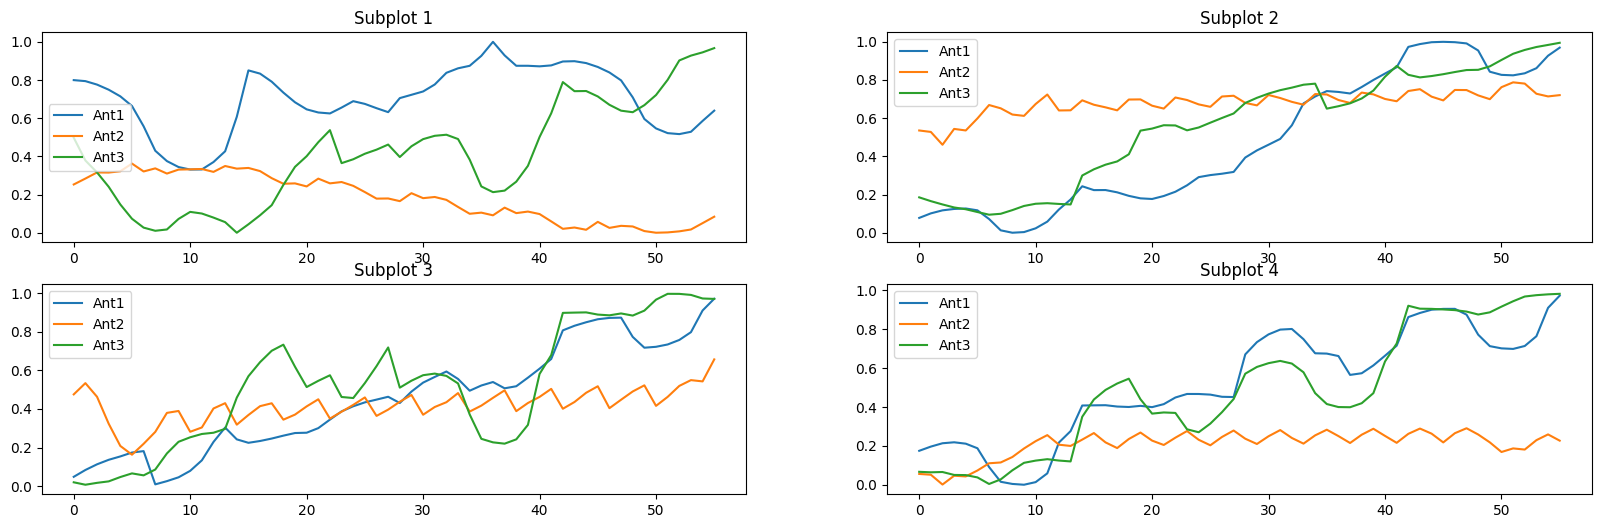

In [10]:
import matplotlib.pyplot as plt
feature=0
fig, axes = plt.subplots(2, 2, figsize=(20, 6))
for i in range(2):
    for j in range(2):
        index = i * 2 + j
        axes[i, j].plot(train_data[index,1,:,feature], label=f'Ant1')
        axes[i, j].plot(train_data[index,3,:,feature], label=f'Ant2')
        axes[i, j].plot(train_data[index,5,:,feature], label=f'Ant3')
        axes[i, j].set_title(f'Subplot {index + 1}')
        axes[i, j].legend()

# Distance

In [11]:
import torch
import torch.nn.functional as F

# Function to compute Euclidean distance (pairwise) between tensors
def euclidean_distance(x, y):
    return torch.sqrt(torch.sum((x - y) ** 2, dim=-1))

# Function to compute Cosine distance between tensors
def cosine_distance(x, y):
    cos_sim = F.cosine_similarity(x.unsqueeze(1), y.unsqueeze(0), dim=-1)
    return 1 - cos_sim  # Cosine distance is 1 - cosine similarity

# Function to compute pairwise distances (Euclidean for odd, Cosine for even)
def compute_distances(tensor1,tensor2):
    # Split the tensor into odd and even indexed parts along dim=0
    odd_indices1 = tensor1[::2]  # Odd indices (1, 3, 5, 7, 9, 11)
    even_indices1 = tensor1[1::2]  # Even indices (0, 2, 4, 6, 8, 10)
    odd_indices2 = tensor2[::2]  # Odd indices (1, 3, 5, 7, 9, 11)
    even_indices2 = tensor2[1::2]
    # Compute pairwise Euclidean distance for odd indices (along dim=0)
    euclidean_distances = []
    for i in range(odd_indices1.size(0) - 1):  # Compute pairwise for odd indices
        dist = euclidean_distance(odd_indices1[i], odd_indices2[i])
        euclidean_distances.append(dist)

    # Compute pairwise Cosine distance for even indices (along dim=0)
    cosine_distances = []
    for i in range(even_indices1.size(0) - 1):  # Compute pairwise for even indices
        dist = cosine_distance(even_indices1[i], even_indices2[i+1])
        cosine_distances.append(dist)

    # Convert distances to tensors
    euclidean_distances = torch.stack(euclidean_distances)
    cosine_distances = torch.stack(cosine_distances)

    # Compute the overall average distance
    # First, flatten the distance matrices
    euclidean_distances_flat = euclidean_distances.flatten()
    cosine_distances_flat = cosine_distances.flatten()

    # Compute the mean of each distance type
    mean_euclidean_distance = euclidean_distances_flat.mean().item()
    mean_cosine_distance = cosine_distances_flat.mean().item()

    # Calculate the overall average distance
    overall_average_distance = (mean_euclidean_distance + mean_cosine_distance) / 2
    return overall_average_distance
    # return overall_average_distance, mean_euclidean_distance, mean_cosine_distance

In [12]:
diatance=np.zeros(10)
for i in range(10):
    data1=train_data[i]
    data2=train_data[i+1]
    diatance[i]=compute_distances(data1, data2)

print(diatance)
print(np.mean(diatance))

[0.12905014 0.14370624 0.13877848 0.12435545 0.09998128 0.13985813
 0.14134502 0.12358936 0.12682725 0.13381108]
0.1301302442446635


## Other setting

In [13]:
# import module
import os
import glob
import random
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import logging
from tqdm import tqdm
torch.autograd.set_detect_anomaly(True)

# seed setting
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(0)
workspace_dir = '.'

# Dataset preparation
In this section, we prepare for the dataset for Pytorch

## Create dataset for Pytorch

In order to unified image information, we use the transform function to:
1. Resize image to 64x64
2. Normalize the image

This CrypkoDataset class will be use in Section 4

In [14]:
# prepare for CrypkoDataset

class hDataset(Dataset):
    def __init__(self, X, y=None):
        super(hDataset).__init__()
        self.data = X
        if y is not None:
            # self.label = torch.LongTensor(y)
            self.label = y
        else:
            self.label = None

    def __getitem__(self, idx):
        h = self.data[idx]
        if self.label is not None:
            return h, self.label[idx]
        else:
            return h

    def __len__(self):
        return len(self.data)

# import sys
# sys.path.append('/content/drive/MyDrive/Code-PLA/GAN')
# from model_TPNet import TPNet
import os

def get_dataset():
    train_set = hDataset(train_data, train_label)
    return train_set
# valid_set = hDataset(train_data, train_label)
# valid_set = hDataset(valid_data, valid_label)
# valid_set = hDataset(test_data)

# remove raw feature to save memory
# del train_data, valid_data, valid_label
# gc.collect()

# get dataloader
# train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
# valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'DEVICE: {device}')
# # create model, define a loss function, and optimizer
# net = TPNet(num_classes=output_dim)
# # in_channel = net.fc.in_features
# # net.fc = nn.Linear(in_channel, output_dim)
# net.to(device)

# criterion = nn.CrossEntropyLoss()
# params = [p for p in net.parameters() if p.requires_grad]
# optimizer = optim.Adam(params, lr=learning_rate, weight_decay= weight_decay)

DEVICE: cpu


## Show the image
Show some sample in the dataset

torch.Size([12, 56, 4])
<class 'torch.Tensor'>


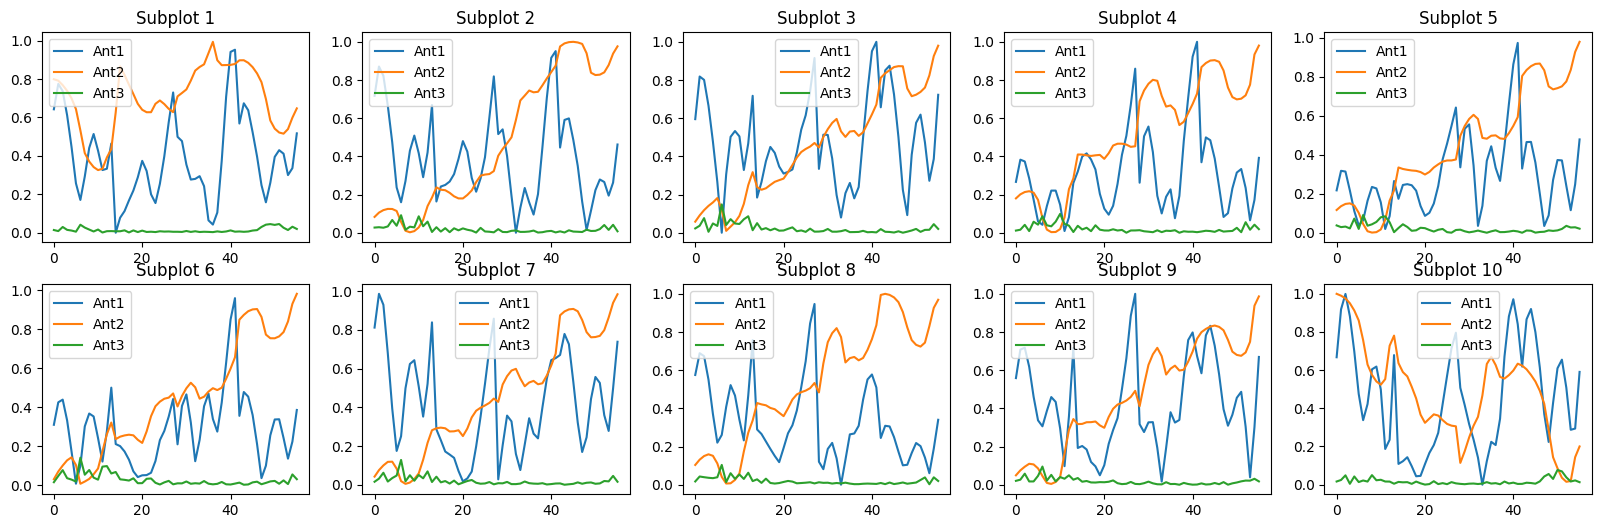

In [15]:
temp_dataset = get_dataset().__getitem__(1)[0]
print(temp_dataset.shape)

print(type(temp_dataset))
# plt.plot(temp_dataset[1,:,1], 'r-')
# for i in range(3):
#     plt.plot(temp_dataset[i,:,0], label=f'Line {i + 1}')
# plt.xlabel('Frequency')
# plt.ylabel('A')
# plt.show()
feature=1
fig, axes = plt.subplots(2, 5, figsize=(20, 6))
for i in range(2):
    for j in range(5):
        index = i * 5 + j
        axes[i, j].plot(get_dataset().__getitem__(index)[0][0,:,feature], label=f'Ant1')
        axes[i, j].plot(get_dataset().__getitem__(index)[0][1,:,feature], label=f'Ant2')
        axes[i, j].plot(get_dataset().__getitem__(index)[0][2,:,feature], label=f'Ant3')
        axes[i, j].set_title(f'Subplot {index + 1}')
        axes[i, j].legend()

# Model setting
In this section, we will create models and trainer.

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## Create Attack model
In this section, we will create models for Generator

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class UpBlock(nn.Module):
    """
    Input:
        x    -> 主干特征 (Input1), 形状 [B, C, H, W]
        skip -> 可选跳连特征 (Input2), 形状与 x 匹配
    Output:
        fused -> 主输出 (Output1), 形状 [B, out_channels, H*, W*]
        aux   -> 辅助输出 (Output2), 形状与 fused 相同，用于下一级 skip
    """
    def __init__(
        self,
        in_channels: int,
        skip_channels: int = 0,
        out_channels: int | None = None,
        aux_channels: int | None = None,
        scale_factor: tuple[int, int] = (2, 2),
    ):
        super().__init__()
        out_channels = out_channels or in_channels
        aux_channels = aux_channels if aux_channels is not None else skip_channels

        # 主路径：多尺度卷积
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=5, padding=2, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=7, padding=3, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
        )

        # 上采样：保持二维缩放，可按流程图灵活配置
        self.upsample_main = (
            nn.Identity() if scale_factor == (1, 1)
            else nn.Upsample(scale_factor=scale_factor, mode="nearest")
        )

        # 跳连路径（可选）
        self.has_skip = skip_channels > 0
        if self.has_skip:
            self.upsample_skip = (
                nn.Identity() if scale_factor == (1, 1)
                else nn.Upsample(scale_factor=scale_factor, mode="nearest")
            )
            self.skip_proj = nn.Sequential(
                nn.Conv2d(skip_channels, skip_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(skip_channels),
                nn.ReLU(inplace=True),
            )
            fusion_in_channels = in_channels + skip_channels
        else:
            self.skip_proj = None
            fusion_in_channels = in_channels

        # 融合输出
        self.fusion_proj = nn.Sequential(
            nn.Conv2d(fusion_in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

        # 额外跳连通道可在下个 UpBlock 使用
        if aux_channels > 0:
            self.aux_proj = nn.Sequential(
                nn.Conv2d(fusion_in_channels, aux_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(aux_channels),
                nn.ReLU(inplace=True),
            )
        else:
            self.aux_proj = None

    def forward(self, x: torch.Tensor, skip: torch.Tensor | None = None):
        x = self.conv3(x)
        x = self.conv5(x)
        x = self.conv7(x)
        x = self.upsample_main(x)

        if self.has_skip and skip is not None:
            skip = self.upsample_skip(skip)
            skip = self.skip_proj(skip)
            fused_input = torch.cat([x, skip], dim=1)
        else:
            fused_input = x

        fused = self.fusion_proj(fused_input)
        aux = self.aux_proj(fused_input) if self.aux_proj is not None else None
        return fused, aux


class DecoderGenerator(nn.Module):
    def __init__(
        self,
        noise_dim: int = 12,
        base_channels: int = 128,
        target_hw: tuple[int, int] = (56, 4),  # (H, W)
        out_channels: int = 12,
    ):
        super().__init__()
        self.target_h, self.target_w = target_hw

        # 设定底层分辨率，使得逐级上采样后恰好到 56×4
        init_h, init_w = 7, 1
        assert self.target_h % init_h == 0 and self.target_w % init_w == 0, \
            "target_h/target_w 必须是 init_h/init_w 的整数倍，方便上采样堆叠"

        self.fc1 = nn.Linear(noise_dim, 256)
        self.fc2 = nn.Linear(256, base_channels * init_h * init_w)

        # 高度放大 7→14→28→56；宽度放大 1→2→4
        scale_plan = [
            (2, 1),  # 7×1 → 14×1
            (2, 1),  # 14×1 → 28×1
            (2, 1),  # 28×1 → 56×1
            (1, 2),  # 56×1 → 56×2
            (1, 2),  # 56×2 → 56×4
        ]
        self.up_blocks = nn.ModuleList()
        in_ch = base_channels
        skip_ch = 0
        for scale in scale_plan:
            block = UpBlock(
                in_channels=in_ch,
                skip_channels=skip_ch,
                out_channels=base_channels,
                aux_channels=base_channels,
                scale_factor=scale,
            )
            self.up_blocks.append(block)
            skip_ch = base_channels  # 后续 block 接收上级输出
            in_ch = base_channels

        # 多分支输出头：3×3、5×5、7×7 并行，再拼成最终 12 通道
        branch_out = out_channels // 3  # 这里让三个分支均分通道
        remainder = out_channels - branch_out * 3
        self.branch1 = nn.Sequential(
            nn.Conv2d(base_channels, branch_out, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(branch_out),
            nn.ReLU(inplace=True),
        )
        self.branch2 = nn.Sequential(
            nn.Conv2d(base_channels, branch_out, kernel_size=5, padding=2, bias=False),
            nn.BatchNorm2d(branch_out),
            nn.ReLU(inplace=True),
        )
        self.branch3 = nn.Sequential(
            nn.Conv2d(base_channels, branch_out + remainder, kernel_size=7, padding=3, bias=False),
            nn.BatchNorm2d(branch_out + remainder),
            nn.ReLU(inplace=True),
        )

    def forward(self, z: torch.Tensor):
        if z.dim() > 2:
            z = z.view(z.size(0), -1)
        x = F.relu(self.fc1(z), inplace=True)
        x = F.relu(self.fc2(x), inplace=True)

        batch = z.size(0)
        init_h, init_w = 7, 1
        x = x.view(batch, -1, init_h, init_w)

        skip = None
        for block in self.up_blocks:
            x, skip = block(x, skip)

        # 最终输出拼接成 (B, 12, 56, 4)
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        out3 = self.branch3(x)
        fake = torch.cat([out1, out2, out3], dim=1)
        return fake


## Create PLA model
In this section, we will create models for Discriminator

In [18]:
# Discriminator
import torch
import torch.nn as nn
import torch.nn.functional as F


class EncoderDiscriminator(nn.Module):
    def __init__(
        self,
        in_channels: int = 12,
        base_channels: int = 16,
        latent_dim: int = 64,
        use_batchnorm: bool = True,
    ):
        super().__init__()
        # 下游 block 数量与通道扩增，可根据流程图改动
        self.conv_blocks = nn.Sequential(
            self._block(in_channels, base_channels, use_batchnorm=False),
            self._block(base_channels, base_channels * 2, use_batchnorm=use_batchnorm),
            self._block(base_channels * 2, base_channels * 4, use_batchnorm=use_batchnorm),
            self._block(base_channels * 4, base_channels * 8, use_batchnorm=use_batchnorm),
            # self._block(base_channels * 8, base_channels * 16, use_batchnorm=use_batchnorm),
            self._block(base_channels * 8, base_channels * 16, use_batchnorm=use_batchnorm),
        )
        # 编码后的全局特征，用于构建潜在向量和判别输出
        self.feature_proj = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(base_channels * 16, latent_dim),
            nn.ReLU(inplace=True),
        )
        self.discriminator_head = nn.Linear(latent_dim, 2)

    def _block(self, in_ch, out_ch, use_batchnorm):
        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size=(4,2), stride=2, padding=1, bias=not use_batchnorm)
        ]
        if use_batchnorm:
            layers.append(nn.BatchNorm2d(out_ch))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return nn.Sequential(*layers)

    def forward(self, x):
        features = self.conv_blocks(x)
        latent = self.feature_proj(features)              # encoder 输出向量
        logits = self.discriminator_head(latent)          # 判别器打分
        logits = F.softmax(logits, dim=1)
        # return logits.squeeze(-1), latent
        return logits


## Create trainer
In this section, we will create a trainer which contains following functions:
1. prepare_environment: prepare the overall environment, construct the models, create directory for the log and ckpt
2. train: train for generator and discriminator, you can try to modify the code here to construct WGAN or WGAN-GP
3. inference: after training, you can pass the generator ckpt path into it and the function will save the result for you

In [23]:
class TrainerGAN():
    def __init__(self, config):
        self.config = config

        # self.G = Generator(3)
        self.G = DecoderGenerator()
        # self.D = Discriminator(3)
        self.D = EncoderDiscriminator()

        self.loss_G = nn.CrossEntropyLoss()
        self.loss_D = nn.CrossEntropyLoss()

        """
        NOTE FOR SETTING OPTIMIZER:

        GAN: use Adam optimizer
        WGAN: use RMSprop optimizer
        WGAN-GP: use Adam optimizer
        """
        # self.opt_D = torch.optim.Adam(self.D.parameters(), lr=self.config["lr"], betas=(0.5, 0.999))
        self.opt_D = torch.optim.Adam(self.D.parameters(), lr=self.config["D_lr"], weight_decay= 1e-5)
        self.opt_G = torch.optim.Adam(self.G.parameters(), lr=self.config["G_lr"], betas=(0.5, 0.999))

        self.dataloader = None
        self.log_dir = os.path.join(self.config["workspace_dir"], 'logs')
        self.ckpt_dir = os.path.join(self.config["workspace_dir"], 'checkpoints')

        FORMAT = '%(asctime)s - %(levelname)s: %(message)s'
        logging.basicConfig(level=logging.INFO,
                            format=FORMAT,
                            datefmt='%Y-%m-%d %H:%M')

        self.steps = 0
        # self.z_samples = Variable(torch.randn(100, self.config["z_dim"])).cuda()


    def prepare_environment(self):
        """
        Use this funciton to prepare function
        """
        os.makedirs(self.log_dir, exist_ok=True)
        os.makedirs(self.ckpt_dir, exist_ok=True)

        # update dir by time
        time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
        self.log_dir = os.path.join(self.log_dir, f'{self.config["model_type"]}')
        self.ckpt_dir = os.path.join(self.ckpt_dir, f'{self.config["model_type"]}')
        os.makedirs(self.log_dir,exist_ok=True)
        os.makedirs(self.ckpt_dir,exist_ok=True)

        # create dataset by the above function
        # dataset = get_dataset()
        train_set = hDataset(train_data, train_label)
        # train_set = hDataset(F_Alice, Label_Alice)
        self.dataloader = DataLoader(train_set, batch_size=self.config["batch_size"], shuffle=True, num_workers=0)
        # self.vaild_set = hDataset(test_data,test_label)
        # self.vaild_set = hDataset(train_data,train_label)
        # self.z_samples = self.vaild_set.__getitem__(1)
        # model preparation
        self.G = self.G.to(device)
        self.D = self.D.to(device)

        self.G.train()
        # self.D.train()
    def gp(self):
        """
        Implement gradient penalty function
        """
        pass

    def train(self):
        """
        Use this function to train generator and discriminator
        """
        self.prepare_environment()
        # self.Loss=torch.ones(1).to(device)
        patience=self.config["n_patience"]
        stale=0
        best_acc=0
        acc=0
        Min_loss=10
        train_accss=[]
        train_accs=[]
        G_losses=[]
        D_losses=[]
        vaild_acces=[]

        for e, epoch in enumerate(range(self.config["n_epoch"])):
            self.D.train()
            D_path=f'{workspace_dir}/checkpoints/GAN_TPNet/D_best.pth'
            G_path=f'{workspace_dir}/checkpoints/GAN_TPNet/G_LSTM_best.pth'
            # self.G.load_state_dict(torch.load(G_path))
            # self.D.load_state_dict(torch.load(D_path))
            progress_bar = tqdm(self.dataloader)
            progress_bar.set_description(f"Epoch {e+1}")

            for loop, data in enumerate(progress_bar):
                # 导入真实训练样本
                r_m, label =data
                r_label = label.to(device)
                # print("r_label",r_label)
                bs = r_m.size(0)
                r_imgs = r_m.to(torch.float32).to(device)
                # print("r_imgs input shape:", r_imgs.shape)

                # *********************
                # *    Train D        *
                # *********************
                # z = Variable(torch.randn(bs, self.config["z_dim"])).to(device)
                self.D.train()
                self.G.eval()
                #生成对抗样本
                with torch.no_grad():
                   z_noise = torch.randn(bs, self.config["z_dim"], 1, 1, device=device, requires_grad=False)
                   fake_imgs = self.G(z_noise)
                # 此处保留梯度
                # print("fake_imgs input shape:", fake_imgs.shape)
                f_label = torch.zeros((bs)).to(device)  # Alice1 Eve0

                # Discriminator forwarding
                r_logit = self.D(r_imgs)
                f_logit = self.D(fake_imgs)

                # print(r_logit.argmax(dim=-1))
                # print(r_label)
                # print(f_logit.argmax(dim=-1))
                # print(f_label)

                """
                NOTE FOR SETTING DISCRIMINATOR LOSS:

                GAN:
                    loss_D = (r_loss + f_loss)/2
                WGAN:
                    loss_D = -torch.mean(r_logit) + torch.mean(f_logit)
                WGAN-GP:
                    gradient_penalty = self.gp(r_imgs, f_imgs)
                    loss_D = -torch.mean(r_logit) + torch.mean(f_logit) + gradient_penalty
                """

                # Loss for discriminator
                r_loss = self.loss_D(r_logit, r_label.long())
                f_loss = self.loss_D(f_logit, f_label.long())
                loss_D = (r_loss + f_loss) / 2
                # print(r_loss)
                # print(f_loss)
                # print(loss_D)

                # Discriminator backwarding
                self.opt_D.zero_grad()
                loss_D.backward()
                self.opt_D.step()

                """
                NOTE FOR SETTING WEIGHT CLIP:

                WGAN: below code
                """

                acc=(r_logit.argmax(dim=-1) == r_label.to(device)).float().mean()
                train_accs.append(acc)
                lossd=loss_D.item()
                D_losses.append(lossd)
                # print(D_losses)

                # *********************
                # *    Train G        *
                # *********************
                if self.steps % self.config["n_critic"] == 0:
                    self.G.train()
                    self.D.eval()
                    # Generate some fake images.
                    z_noise=torch.randn(bs, self.config["z_dim"], 1, 1, device=device, requires_grad=False)
                    fake_imgs = self.G(z_noise)

                    # Generator forwarding
                    f_logit = self.D(fake_imgs)             # 此处保留梯度
                    fr_label = torch.ones((bs)).to(device)
                    # print(f_logit.argmax(dim=-1))
                    # print(fr_label)

                    """
                    NOTE FOR SETTING LOSS FOR GENERATOR:

                    GAN: loss_G = self.loss(f_logit, r_label)
                    WGAN: loss_G = -torch.mean(self.D(f_imgs))
                    WGAN-GP: loss_G = -torch.mean(self.D(f_imgs))
                    """
                    # Loss for the generator.
                    loss_G = self.loss_G(f_logit, fr_label.long())

                    # Generator backwarding
                    self.opt_G.zero_grad()
                    loss_G.backward()
                    self.opt_G.step()

                    G_losses.append(loss_G.item())

                if self.steps % 10 == 0:
                    G_meanloss=np.mean(G_losses)
                    progress_bar.set_postfix(loss_G=G_meanloss, loss_D=loss_D.item(), best_acc=best_acc)
                self.steps += 1

            # train_loss = sum(train_loss) / len(train_loss)
            train_acc = sum(train_accs) / len(train_accs)
            # train_losses.append(train_loss)
            train_accss.append(np.array(train_acc.cpu()))
            # Print the information.
            print(f"[ Train | {epoch + 1:03d}/{epoch:03d} ] loss = {loss_D:.5f}, acc = {train_acc:.5f}")

            # D_path=f'{workspace_dir}/checkpoints/GAN/D_best.pth'
            # acc, loss_T1 = self.PLAtest(D_path, test_data, test_label)
            vaild_acc, loss_T1 = self.PLAtest(D_path, train_data, train_label)
            vaild_acces.append(vaild_acc)
            # print(loss_T1)
            # if epoch==0:
            #     best_acc=acc
            # acc=0.1
            loss_T=G_meanloss
            if vaild_acc > best_acc:
                # Save the checkpoints.
                # torch.save(self.G.state_dict(), os.path.join(self.ckpt_dir, f'G_best.pth'))
                torch.save(self.D.state_dict(), D_path)
                # print(self.Loss)
                print(vaild_acc)
                best_acc = vaild_acc
                stale = 0
            else:
                stale += 1
                if stale > patience:
                    print(f"No improvment {patience} consecutive epochs, early stopping")
                    break
            if loss_T < Min_loss:
                # Save the checkpoints.
                torch.save(self.G.state_dict(), G_path)
                # torch.save(self.D.state_dict(), os.path.join(self.ckpt_dir, f'D_best.pth'))
                # print(self.Loss)
                print(loss_T)
                Min_loss = loss_T

            # self.G.eval()
            # # f_imgs_sample = (self.G(self.z_samples.to(device)).data + 1) / 2.0
            # fig, axes = plt.subplots(2, 5, figsize=(15, 6))
            # for i in range(2):
            #     for j in range(5):
            #         index = i * 5 + j
            #         axes[i, j].plot(f_imgs[index][0,:,feature].cpu(), label=f'Ant1')
            #         axes[i, j].plot(f_imgs[index][1,:,feature].cpu(), label=f'Ant2')
            #         axes[i, j].plot(f_imgs[index][2,:,feature].cpu(), label=f'Ant3')
            #         axes[i, j].set_title(f'Subplot {index + 1}')
            #         axes[i, j].legend()

        logging.info('Finish training')
        # print(D_losses)
        fig, axes = plt.subplots(1, 2, figsize=(15, 6), squeeze=False)
        axes[0, 0].plot(D_losses, label=f'D_losses')
        axes[0, 0].plot(G_losses, label=f'G_losses')
        axes[0, 1].plot(train_accss, label=f'train_accss')
        axes[0, 1].plot(vaild_acces, label=f'vaild_acces')
        axes[0, 0].legend()
        axes[0, 1].legend()



    def PLAtest(self, D_path, PLAtest_data, PLAtest_label):
        """
        1. D_path is the path for Generator ckpt
        2. You can use this function to generate final answer
        """
        # self.D.load_state_dict(torch.load(D_path))
        self.D.to(device)
        self.D.eval()
        test_set = hDataset(PLAtest_data, PLAtest_label)
        test_dataloader = DataLoader(test_set, batch_size=self.config["batch_size"], shuffle=False, num_workers=0)
        prediction = []
        valid_accss = []
        valid_accs=[]
        with torch.no_grad():
            for data, labels in test_dataloader:
                data = data.to(torch.float32).to(device)
                rt_logit = self.D(data)
                # label=label.float()
                # print(label)
                losst=self.loss_D(rt_logit, labels.long().to(device))
                losst.requires_grad_()
                # print(rt_logit)
                # test_lab = np.round(rt_logit.cpu().data.numpy())
                acc = (rt_logit.argmax(dim=-1) == labels.to(device)).float().mean()
                valid_accs.append(acc)
                # test_lab = np.argmax(rt_logit.cpu().data.numpy(), axis=1)
                # print(test_lab)
                # prediction += test_lab.squeeze().tolist()
        # print(prediction)
        # valid_loss = sum(valid_loss) / len(valid_loss)
        valid_acc = sum(valid_accs) / len(valid_accs)
        # valid_losses.append(valid_loss)
        valid_accss.append(np.array(valid_acc.cpu()))
        # Print the information.
        print(f"[ Valid | ] loss = {losst:.5f}, acc = {valid_acc:.5f}")
        # accuracy=1 - np.count_nonzero(np.array(prediction)-np.array(PLAtest_label))/len(prediction)

        return valid_acc.item(), losst.item()

# Train
In this section, we will first set the config for trainer, then use it to train generator and discriminator

## Set config

In [20]:
config = {
    "model_type": "GAN_TPNet",
    "batch_size": 100,
    "D_lr": 0.00005,
    "G_lr": 0.00005,
    "n_epoch": 1000,
    "n_patience": 50,
    "z_dim":  12,
    "n_critic": 1,
    "workspace_dir": workspace_dir, # define in the environment setting
}


## Start to train

In [21]:
trainer = TrainerGAN(config)
trainer.train()

Epoch 1: 100%|██████████| 1/1 [00:13<00:00, 13.65s/it, best_acc=0, loss_D=0.682, loss_G=0.698]


[ Train | 001/000 ] loss = 0.68235, acc = 0.54082
[ Valid | ] loss = 0.69316, acc = 0.50000
0.5
0.6978901624679565


Epoch 2: 100%|██████████| 1/1 [00:14<00:00, 14.14s/it]


[ Train | 002/001 ] loss = 0.67610, acc = 0.57653
[ Valid | ] loss = 0.69315, acc = 0.50000


Epoch 3: 100%|██████████| 1/1 [00:12<00:00, 12.80s/it]


[ Train | 003/002 ] loss = 0.67420, acc = 0.60884
[ Valid | ] loss = 0.69312, acc = 0.50000


Epoch 4: 100%|██████████| 1/1 [00:12<00:00, 12.73s/it]


[ Train | 004/003 ] loss = 0.66790, acc = 0.64286
[ Valid | ] loss = 0.69309, acc = 0.50000


Epoch 5: 100%|██████████| 1/1 [00:12<00:00, 12.30s/it]


[ Train | 005/004 ] loss = 0.66455, acc = 0.67347
[ Valid | ] loss = 0.69303, acc = 0.50000


Epoch 6: 100%|██████████| 1/1 [00:12<00:00, 12.37s/it]


[ Train | 006/005 ] loss = 0.65701, acc = 0.69898
[ Valid | ] loss = 0.69293, acc = 0.50000


Epoch 7: 100%|██████████| 1/1 [00:12<00:00, 12.48s/it]


[ Train | 007/006 ] loss = 0.65137, acc = 0.71866
[ Valid | ] loss = 0.69281, acc = 0.50000


Epoch 8: 100%|██████████| 1/1 [00:12<00:00, 12.78s/it]


[ Train | 008/007 ] loss = 0.64633, acc = 0.73469
[ Valid | ] loss = 0.69271, acc = 0.50000


Epoch 9: 100%|██████████| 1/1 [00:12<00:00, 12.72s/it]


[ Train | 009/008 ] loss = 0.64176, acc = 0.75170
[ Valid | ] loss = 0.69254, acc = 0.50000


Epoch 10: 100%|██████████| 1/1 [00:12<00:00, 12.75s/it]


[ Train | 010/009 ] loss = 0.63963, acc = 0.76633
[ Valid | ] loss = 0.69225, acc = 0.50000


Epoch 11: 100%|██████████| 1/1 [00:12<00:00, 12.94s/it, best_acc=0.5, loss_D=0.633, loss_G=0.702]


[ Train | 011/010 ] loss = 0.63273, acc = 0.77829
[ Valid | ] loss = 0.69158, acc = 0.50000


Epoch 12: 100%|██████████| 1/1 [00:18<00:00, 18.83s/it]


[ Train | 012/011 ] loss = 0.62726, acc = 0.78912
[ Valid | ] loss = 0.69053, acc = 0.50000


Epoch 13: 100%|██████████| 1/1 [00:13<00:00, 13.13s/it]


[ Train | 013/012 ] loss = 0.62327, acc = 0.79827
[ Valid | ] loss = 0.68943, acc = 0.50000


Epoch 14: 100%|██████████| 1/1 [00:14<00:00, 14.21s/it]


[ Train | 014/013 ] loss = 0.62108, acc = 0.80758
[ Valid | ] loss = 0.68816, acc = 0.50000


Epoch 15: 100%|██████████| 1/1 [00:14<00:00, 14.35s/it]


[ Train | 015/014 ] loss = 0.61641, acc = 0.81633
[ Valid | ] loss = 0.68686, acc = 0.50000


Epoch 16: 100%|██████████| 1/1 [00:12<00:00, 12.83s/it]


[ Train | 016/015 ] loss = 0.61358, acc = 0.82398
[ Valid | ] loss = 0.68524, acc = 0.50000


Epoch 17: 100%|██████████| 1/1 [00:12<00:00, 13.00s/it]


[ Train | 017/016 ] loss = 0.60954, acc = 0.83133
[ Valid | ] loss = 0.68267, acc = 0.50000


Epoch 18: 100%|██████████| 1/1 [00:14<00:00, 14.47s/it]


[ Train | 018/017 ] loss = 0.60636, acc = 0.83844
[ Valid | ] loss = 0.67951, acc = 0.50000


Epoch 19: 100%|██████████| 1/1 [00:12<00:00, 12.80s/it]


[ Train | 019/018 ] loss = 0.59985, acc = 0.84479
[ Valid | ] loss = 0.67572, acc = 0.50000


Epoch 20: 100%|██████████| 1/1 [00:14<00:00, 14.86s/it]


[ Train | 020/019 ] loss = 0.59856, acc = 0.85051
[ Valid | ] loss = 0.67064, acc = 0.50000


Epoch 21: 100%|██████████| 1/1 [00:13<00:00, 13.30s/it, best_acc=0.5, loss_D=0.597, loss_G=0.639]


[ Train | 021/020 ] loss = 0.59683, acc = 0.85569
[ Valid | ] loss = 0.66494, acc = 0.50000
0.638931040252958


Epoch 22: 100%|██████████| 1/1 [00:12<00:00, 12.91s/it]


[ Train | 022/021 ] loss = 0.58904, acc = 0.86039
[ Valid | ] loss = 0.65782, acc = 0.50000


Epoch 23: 100%|██████████| 1/1 [00:12<00:00, 12.82s/it]


[ Train | 023/022 ] loss = 0.58542, acc = 0.86468
[ Valid | ] loss = 0.64919, acc = 0.52041
0.5204081535339355


Epoch 24: 100%|██████████| 1/1 [00:13<00:00, 13.14s/it]


[ Train | 024/023 ] loss = 0.58287, acc = 0.86905
[ Valid | ] loss = 0.63907, acc = 0.53061
0.5306122303009033


Epoch 25: 100%|██████████| 1/1 [00:12<00:00, 12.82s/it]


[ Train | 025/024 ] loss = 0.57976, acc = 0.87306
[ Valid | ] loss = 0.62771, acc = 0.65306
0.6530612111091614


Epoch 26: 100%|██████████| 1/1 [00:13<00:00, 13.37s/it]


[ Train | 026/025 ] loss = 0.57648, acc = 0.87677
[ Valid | ] loss = 0.61588, acc = 0.71429
0.7142857313156128


Epoch 27: 100%|██████████| 1/1 [00:12<00:00, 12.03s/it]


[ Train | 027/026 ] loss = 0.57289, acc = 0.88020
[ Valid | ] loss = 0.60396, acc = 0.77551
0.7755101919174194


Epoch 28: 100%|██████████| 1/1 [00:12<00:00, 12.17s/it]


[ Train | 028/027 ] loss = 0.57062, acc = 0.88338
[ Valid | ] loss = 0.59259, acc = 0.82653
0.8265306353569031


Epoch 29: 100%|██████████| 1/1 [00:12<00:00, 12.71s/it]


[ Train | 029/028 ] loss = 0.56813, acc = 0.88635
[ Valid | ] loss = 0.58236, acc = 0.83673
0.8367347121238708


Epoch 30: 100%|██████████| 1/1 [00:13<00:00, 13.57s/it]


[ Train | 030/029 ] loss = 0.56563, acc = 0.88912
[ Valid | ] loss = 0.57347, acc = 0.84694
0.8469387888908386


Epoch 31: 100%|██████████| 1/1 [00:12<00:00, 12.93s/it, best_acc=0.847, loss_D=0.563, loss_G=0.538]


[ Train | 031/030 ] loss = 0.56333, acc = 0.89170
[ Valid | ] loss = 0.56570, acc = 0.85714
0.8571428656578064
0.5377459006924783


Epoch 32: 100%|██████████| 1/1 [00:12<00:00, 12.73s/it]


[ Train | 032/031 ] loss = 0.56035, acc = 0.89413
[ Valid | ] loss = 0.55932, acc = 0.85714


Epoch 33: 100%|██████████| 1/1 [00:13<00:00, 13.05s/it]


[ Train | 033/032 ] loss = 0.55752, acc = 0.89641
[ Valid | ] loss = 0.55401, acc = 0.85714


Epoch 34: 100%|██████████| 1/1 [00:13<00:00, 13.07s/it]


[ Train | 034/033 ] loss = 0.55553, acc = 0.89856
[ Valid | ] loss = 0.55003, acc = 0.85714


Epoch 35: 100%|██████████| 1/1 [00:17<00:00, 17.83s/it]


[ Train | 035/034 ] loss = 0.55339, acc = 0.90087
[ Valid | ] loss = 0.54704, acc = 0.84694


Epoch 36: 100%|██████████| 1/1 [00:13<00:00, 13.51s/it]


[ Train | 036/035 ] loss = 0.55169, acc = 0.90306
[ Valid | ] loss = 0.54513, acc = 0.84694


Epoch 37: 100%|██████████| 1/1 [00:14<00:00, 14.86s/it]


[ Train | 037/036 ] loss = 0.55009, acc = 0.90513
[ Valid | ] loss = 0.54411, acc = 0.84694


Epoch 38: 100%|██████████| 1/1 [00:16<00:00, 16.09s/it]


[ Train | 038/037 ] loss = 0.54858, acc = 0.90709
[ Valid | ] loss = 0.54427, acc = 0.84694


Epoch 39: 100%|██████████| 1/1 [00:14<00:00, 14.74s/it]


[ Train | 039/038 ] loss = 0.54596, acc = 0.90895
[ Valid | ] loss = 0.54537, acc = 0.84694


Epoch 40: 100%|██████████| 1/1 [00:13<00:00, 13.50s/it]


[ Train | 040/039 ] loss = 0.54465, acc = 0.91071
[ Valid | ] loss = 0.54708, acc = 0.83673


Epoch 41: 100%|██████████| 1/1 [00:13<00:00, 13.34s/it, best_acc=0.857, loss_D=0.543, loss_G=0.483]


[ Train | 041/040 ] loss = 0.54303, acc = 0.91239
[ Valid | ] loss = 0.54938, acc = 0.82653
0.48307070281447434


Epoch 42: 100%|██████████| 1/1 [00:13<00:00, 13.58s/it]


[ Train | 042/041 ] loss = 0.54108, acc = 0.91399
[ Valid | ] loss = 0.55233, acc = 0.80612


Epoch 43: 100%|██████████| 1/1 [00:13<00:00, 13.12s/it]


[ Train | 043/042 ] loss = 0.53877, acc = 0.91552
[ Valid | ] loss = 0.55505, acc = 0.80612


Epoch 44: 100%|██████████| 1/1 [00:12<00:00, 12.95s/it]


[ Train | 044/043 ] loss = 0.53648, acc = 0.91698
[ Valid | ] loss = 0.55821, acc = 0.78571


Epoch 45: 100%|██████████| 1/1 [00:12<00:00, 12.91s/it]


[ Train | 045/044 ] loss = 0.53440, acc = 0.91837
[ Valid | ] loss = 0.56203, acc = 0.74490


Epoch 46:   0%|          | 0/1 [00:04<?, ?it/s]


KeyboardInterrupt: 

# Test
In this section, we will use trained model to test model

## Inference through trainer

In [22]:
D_path=f'{workspace_dir}/checkpoints/GAN_TPNet/D_best.pth'
acc = trainer.PLAtest(D_path, test_data, test_label)
print(acc)
acc = trainer.PLAtest(D_path, F_Alice, Label_Alice)
print(acc)
acc = trainer.PLAtest(D_path, F_Eve, Label_Eve)
print(acc)
acc = trainer.PLAtest(D_path, F_Alice2, Label_Eve)
print(acc)
acc = trainer.PLAtest(D_path, F_Eve2, Label_Eve)
print(acc)

[ Valid | ] loss = 0.58110, acc = 0.61224
(0.6122449040412903, 0.581095278263092)
[ Valid | ] loss = 0.73026, acc = 0.31633
(0.3163265287876129, 0.7302637100219727)
[ Valid | ] loss = 0.41708, acc = 1.00000
(1.0, 0.4170778691768646)
[ Valid | ] loss = 0.55048, acc = 0.93878
(0.9387755393981934, 0.5504842400550842)
[ Valid | ] loss = 0.47587, acc = 1.00000
(1.0, 0.4758700132369995)


In [ ]:
G=AttackGenerator()
G.to(device)
G.eval()
z=np.zeros((records,56,3*2))
for i in range(records):
    z[i,:] = complexH_to_RIseq(CSI_Eve[i,:])
# print(CSI_Eve.shape)
z=torch.tensor(z, dtype=torch.float32).to(device)
# print(z.shape)
z = G(z)
z = z.cpu().detach().numpy()

f_z=np.zeros((records,3,56), dtype=complex)
for i in range(records):
    f_z[i,:] = RIseq_to_complexH(z[i,:])
F_z = Alice_Eve_CSIimage(f_z,w)
acc = trainer.PLAtest(D_path, F_z, Label_Eve)
print(acc)

In [ ]:
# import matplotlib.pyplot as plt
feature=0
fig, axes = plt.subplots(2, 5, figsize=(20, 6))
for i in range(2):
    for j in range(5):
        index = i * 5 + j
        axes[i, j].plot(F_z[index,0,:,feature], label=f'Ant1')
        axes[i, j].plot(F_z[index,1,:,feature], label=f'Ant2')
        axes[i, j].plot(F_z[index,2,:,feature], label=f'Ant3')
        axes[i, j].set_title(f'Subplot {index + 1}')
        axes[i, j].legend()